# BNB Linked Data Platform

The [BNB Linked Data Platform](https://bnb.data.bl.uk/) provides access to the [British National Bibliography (BNB)](http://www.bl.uk/bibliographic/natbib.html) published as linked open data and made available through SPARQL services. 

This notebook explains how to query the repository and obtain places of publication (fields blt:publication and blt:projectedPublication ) to show an interactive map. Thanks that the works are linked to [GeoNames](https://www.geonames.org/), the records can be linked to external repositories. This notebook  obtains information from [Wikidata](https://www.wikidata.org), showing the benefits of Linked Open Data.

## Global configuration

In this section, you can set the author from the BNB by using its identifier. 

In [44]:
#bnbIdAuthor = 'http://bnb.data.bl.uk/id/person/DickensCharles1812-1870'
#bnbIdAuthor = 'https://bnb.data.bl.uk/doc/person/BlakeWilliam1757-1827'
bnbIdAuthor = 'http://bnb.data.bl.uk/id/person/ShakespeareWilliam1564-1616'

## Setting up things

In [45]:
import folium
import requests
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize  

## Let's query the repository by asking the publications related to William Shakespeare
We will use the [SPARQL endpoint](https://bnb.data.bl.uk/flint-sparql) to create the query and configure the request to retrieve json as a result.

In [46]:
url = 'https://bnb.data.bl.uk/sparql'
query = """
PREFIX bibo: <http://purl.org/ontology/bibo/>
PREFIX bio: <http://purl.org/vocab/bio/0.1/>
PREFIX blt: <http://www.bl.uk/schemas/bibliographic/blterms#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX event: <http://purl.org/NET/c4dm/event.owl#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX isbd: <http://iflastandards.info/ns/isbd/elements/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdau: <http://rdaregistry.info/Elements/u/>
PREFIX madsrdf: <http://www.loc.gov/mads/rdf/v1#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX void: <http://rdfs.org/ns/void#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX umbel: <http://umbel.org/umbel#>
PREFIX schema: <http://schema.org/>
PREFIX c4dm: <http://purl.org/NET/c4dm/event.owl#>

SELECT DISTINCT ?resource ?title ?date ?place WHERE {{
   graph <http://bnb.data.bl.uk/id/graph/BNBCIP> {{
      ?resource ?p <{0}> ;
         dct:title ?title ;
         schema:datePublished ?date .
      OPTIONAL {{
          ?resource blt:projectedPublication ?publication .
          ?publication c4dm:place ?place .
          FILTER regex(?place, "geonames", "i")        
      }}
      OPTIONAL {{
          ?resource blt:publication ?publication .
          ?publication c4dm:place ?place .
          FILTER regex(?place, "geonames", "i")        
      }}
   }}
}} LIMIT 500
"""

query = query.format(bnbIdAuthor)

# use json as a result
headers = {'Accept': 'application/sparql-results+json'}
r = requests.get(url, params = {'format': 'application/sparql-results+json', 'query': query}, headers=headers)
print('Elements retrieved!')

Elements retrieved!


## Save as a CSV 

In [47]:
bnbdata = json.loads(r.text)

csv_out = csv.writer(open('bnb_records.csv', 'w'), delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
csv_out.writerow(['resource', 'place', 'title', 'date'])

for i in bnbdata['results']['bindings']:
    resource = place = title = date =''
    
    resource = i['resource']['value']
    place = i['place']['value']
    title = i['title']['value']
    date = i['date']['value']
    
    csv_out.writerow([resource,place,title,date])

## Exploring the data

In [48]:
# Load the CSV file from GitHub.
# This puts the data in a Pandas DataFrame
df = pd.read_csv('bnb_records.csv')

In [49]:
df

,resource,place,title,date
0,http://bnb.data.bl.uk/id/resource/013310275,http://sws.geonames.org/6269131/,Macbeth : teachit KS3 interactive pack,2006-01
1,http://bnb.data.bl.uk/id/resource/013310276,http://sws.geonames.org/6269131/,Much ado about nothing : teachit KS3 interacti...,2006-01
2,http://bnb.data.bl.uk/id/resource/013315368,http://sws.geonames.org/6269131/,Hamlet,2006-01
3,http://bnb.data.bl.uk/id/resource/019599478,http://sws.geonames.org/6269131/,Twelfth night,2020-01
4,http://bnb.data.bl.uk/id/resource/019599479,http://sws.geonames.org/6269131/,The tempest : the alexander text,2019-11
5,http://bnb.data.bl.uk/id/resource/006937440,http://sws.geonames.org/6269131/,Timon of Athens,2004-04
6,http://bnb.data.bl.uk/id/resource/006954359,http://sws.geonames.org/6269131/,Peter Brook's Hamlet,2001-08
7,http://bnb.data.bl.uk/id/resource/018234698,http://sws.geonames.org/6269131/,A midsummer night's dream,2017-03
8,http://bnb.data.bl.uk/id/resource/018234699,http://sws.geonames.org/6269131/,Macbeth,2017-03
9,http://bnb.data.bl.uk/id/resource/018915583,http://sws.geonames.org/6269131/,Shakespeare's sonnets,2018-07


## How many items?

In [50]:
# How many items?
len(df)

126

### Let's count the number of resources per place

In [51]:
places_by_number = df.groupby("place")["resource"].count()

In [52]:
places_by_number

place
http://sws.geonames.org/1269750/     2
http://sws.geonames.org/2921044/     9
http://sws.geonames.org/6251999/     2
http://sws.geonames.org/6252001/    30
http://sws.geonames.org/6269131/    83
Name: resource, dtype: int64

In [53]:
### We can access the count of each place

In [54]:
places_by_number[['http://sws.geonames.org/6269131/']][0]

83

In [55]:
### Create a chart to visualize the results

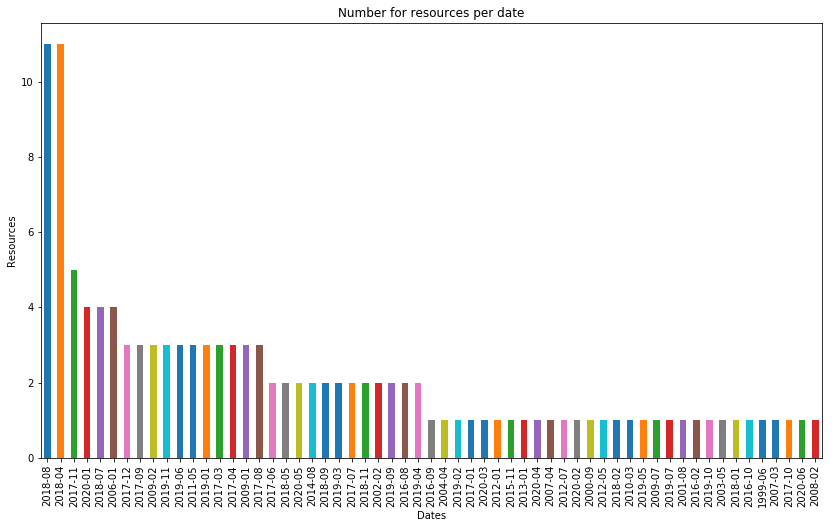

In [56]:
ax = df['date'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for resources per date")
ax.set_xlabel("Dates")
ax.set_ylabel("Resources")
plt.show()

### Let's group the items by year

In [57]:
# First we create a new column in pandas with the year
df['year'] = pd.DatetimeIndex(df['date']).year

In [58]:
df['year']

0      2006
1      2006
2      2006
3      2020
4      2019
5      2004
6      2001
7      2017
8      2017
9      2018
10     2011
11     2011
12     2011
13     2016
14     2016
15     2019
16     2019
17     2019
18     2019
19     2019
20     2019
21     2020
22     2020
23     2017
24     2017
25     2017
26     2019
27     2020
28     2000
29     1999
       ... 
96     2019
97     2019
98     2019
99     2018
100    2018
101    2018
102    2018
103    2018
104    2018
105    2018
106    2018
107    2018
108    2018
109    2018
110    2018
111    2018
112    2018
113    2018
114    2018
115    2018
116    2019
117    2019
118    2006
119    2012
120    2020
121    2020
122    2020
123    2020
124    2020
125    2020
Name: year, Length: 126, dtype: int64

In [59]:
### Creating the chart by year

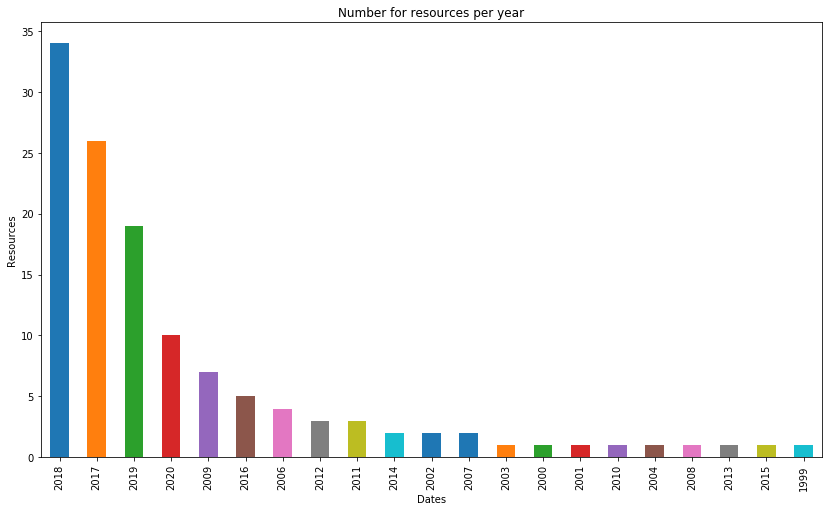

In [60]:
ax = df['year'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for resources per year")
ax.set_xlabel("Dates")
ax.set_ylabel("Resources")
plt.show()

## Exploring the places

In [61]:
# Get unique values
places = pd.unique(df['place']).tolist()
strplaces = ''
for a in sorted(places):
    print(a)
    strplaces = strplaces + ' \"' + a.replace("http://sws.geonames.org/", "").replace("/", "") + '\"'

http://sws.geonames.org/1269750/
http://sws.geonames.org/2921044/
http://sws.geonames.org/6251999/
http://sws.geonames.org/6252001/
http://sws.geonames.org/6269131/


### Getting latitude and longitude from Wikidata

In [62]:
url = 'https://query.wikidata.org/sparql'
query = """
PREFIX bibo: <http://purl.org/ontology/bibo/>
SELECT ?idgeonames ?lat ?lon ?x ?xLabel 
WHERE {{ 
  values ?idgeonames {{ {0} }} 
  ?x wdt:P1566 ?idgeonames ; 
   p:P625 [
     psv:P625 [
       wikibase:geoLatitude ?lat ;
       wikibase:geoLongitude ?lon ;
       wikibase:geoGlobe ?globe ;
     ];
     ps:P625 ?coord
   ]
   SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
}}
"""

query = query.format(strplaces)
print(query)

# use json as a result
r = requests.get(url, params = {'format': 'json', 'query': query})
geopoints = r.json()


PREFIX bibo: <http://purl.org/ontology/bibo/>
SELECT ?idgeonames ?lat ?lon ?x ?xLabel 
WHERE { 
  values ?idgeonames {  "1269750" "2921044" "6251999" "6252001" "6269131" } 
  ?x wdt:P1566 ?idgeonames ; 
   p:P625 [
     psv:P625 [
       wikibase:geoLatitude ?lat ;
       wikibase:geoLongitude ?lon ;
       wikibase:geoGlobe ?globe ;
     ];
     ps:P625 ?coord
   ]
   SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}



### Finally, we add the markers to the map

In [63]:
map = folium.Map(location=[0,0], zoom_start=1.5)

for geo in geopoints['results']['bindings']:
    idwikidata = geo['x']['value']
    lat = geo['lat']['value']
    lon = geo['lon']['value']
    idgeonames = geo['idgeonames']['value']
    label = geo['xLabel']['value']
    print(lat, lon)
    
    # adding a text to the popup
    count = places_by_number[['http://sws.geonames.org/' + idgeonames + '/']][0]
    popup = str(count) + " records published in <a hreh='" + str(idwikidata) + "'>" + label + "</a>"
    
    folium.Marker([lat,lon], popup= popup).add_to(map)

51.0 10.0
38.895 -77.036666666667
22.0 77.0
53.0 -1.0
56.0 -109.0


In [64]:
map